In [1]:
from __future__ import print_function
import os, sys, time, datetime, json, random
import numpy as np
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.optimizers import SGD , Adam, RMSprop
#from keras.layers.advanced_activations import PReLU
#from keras.layers.advanced_activations import LeakyReLU
from keras.layers import PReLU
from keras.layers import LeakyReLU
from keras.activations import relu
import matplotlib.pyplot as plt
%matplotlib inline

# import py.Tmaze
# import py.Qtraining
# import py.Experience'

2023-02-04 16:02:58.332150: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-04 16:02:58.467923: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-04 16:02:58.467945: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-02-04 16:02:59.092370: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [2]:
# Gray scale marks for cells
visited_mark = 0.9
flag_mark = 0.65
agent_mark = 0.5

# Actions dictionary
actions_dict = {
    0: 'left',
    1: 'up',
    2: 'right',
    3: 'down',
}

num_actions = len(actions_dict)

# The Maze Class

In [3]:
# maze is a 2d Numpy array of floats between 0.0 to 1.0
# 1.0 corresponds to a free cell, and 0.0 an occupied cell
# rat = (row, col) initial rat position (defaults to (0,0))

class Tmaze(object):
    """
    Tour De Flags maze object
    maze: a 2d Numpy array of 0's and 1's
        1.00 - a free cell
        0.65 - flag cell
        0.50 - agent cell
        0.00 - an occupied cell
    agent: (row, col) initial agent position (defaults to (0,0))
    flags: list of cells occupied by flags
    """
    def __init__(self, maze, flags, agent=(0,0), target=None):
        self._maze = np.array(maze)
        self._flags = set(flags)
        nrows, ncols = self._maze.shape
        if target is None:
            self.target = (nrows-1, ncols-1)   # default target cell where the agent to deliver the "flags"
        self.free_cells = set((r,c) for r in range(nrows) for c in range(ncols) if self._maze[r,c] == 1.0)
        self.free_cells.discard(self.target)
        self.free_cells -= self._flags
        if self._maze[self.target] == 0.0:
            raise Exception("Invalid maze: target cell cannot be blocked!")
        if not agent in self.free_cells:
            raise Exception("Invalid agent Location: must sit on a free cell")
        self.reset(agent)

    def reset(self, agent=(0,0)):
        self.agent = agent
        self.maze = np.copy(self._maze)
        self.flags = set(self._flags)
        nrows, ncols = self.maze.shape
        row, col = agent
        self.maze[row, col] = agent_mark
        self.state = ((row, col), 'start')
        self.base = np.sqrt(self.maze.size)
        self.visited = dict(((r,c),0) for r in range(nrows) for c in range(ncols) if self._maze[r,c] == 1.0)
        self.total_reward = 0
        self.min_reward = -0.5 * self.maze.size
        self.reward = {
            'blocked':  self.min_reward,
            'flag':     1.0/len(self._flags),
            'invalid': -4.0/self.base,
            'valid':   -1.0/self.maze.size
        }

    def act(self, action):
        self.update_state(action)
        reward = self.get_reward()
        self.total_reward += reward
        status = self.game_status()
        env_state = self.observe()
        return env_state, reward, status

    def get_reward(self):
        agent, mode = self.state
        if agent == self.target:
            return 1.0 - len(self.flags) / len(self._flags)
        if mode == 'blocked':
            return self.reward['blocked']
        elif agent in self.flags:
            return self.reward['flag']
        elif mode == 'invalid':
            return self.reward['invalid']
        elif mode == 'valid':
            return self.reward['valid'] #* (1 + 0.1*self.visited[agent] ** 2)

    def update_state(self, action):
        nrows, ncols = self.maze.shape
        (nrow, ncol), nmode = agent, mode = self.state

        if self.maze[agent] > 0.0:
            self.visited[agent] += 1  # mark visited cell
        if agent in self.flags:
            self.flags.remove(agent)

        valid_actions = self.valid_actions()

        if not valid_actions:
            nmode = 'blocked'
        elif action in valid_actions:
            nmode = 'valid'
            if action == 0:    # move left
                ncol -= 1
            elif action == 1:  # move up
                nrow -= 1
            elif action == 2:    # move right
                ncol += 1
            elif action == 3:  # move down
                nrow += 1
        else:                  # invalid action, no change in agent position
            nmode = 'invalid'

        # new state
        agent = (nrow, ncol)
        self.state = (agent, nmode)

    def game_status(self):
        if self.total_reward < self.min_reward:
            return 'lose'
        agent, mode = self.state
        if agent == self.target:
            if len(self.flags) == 0:
                return 'win'
            else:
                return 'lose'

        return 'ongoing'

    def observe(self):
        canvas = self.draw_env()
        env_state = canvas.reshape((1, -1))
        return env_state

    def draw_env(self):
        canvas = np.copy(self.maze)
        nrows, ncols = self.maze.shape
        # clear all visual marks
        for r in range(nrows):
            for c in range(ncols):
                if canvas[r,c] > 0.0:
                    canvas[r,c] = 1.0
        # draw the flags
        for r,c in self.flags:
            canvas[r,c] = flag_mark
        # draw the agent
        agent, mode = self.state
        canvas[agent] = agent_mark
        return canvas

    def valid_actions(self, cell=None):
        if cell is None:
            (row, col), mode = self.state
        else:
            row, col = cell
        actions = [0, 1, 2, 3]
        nrows, ncols = self.maze.shape
        if row == 0:
            actions.remove(1)
        elif row == nrows-1:
            actions.remove(3)

        if col == 0:
            actions.remove(0)
        elif col == ncols-1:
            actions.remove(2)

        if row>0 and self.maze[row-1,col] == 0.0:
            actions.remove(1)
        if row<nrows-1 and self.maze[row+1,col] == 0.0:
            actions.remove(3)

        if col>0 and self.maze[row,col-1] == 0.0:
            actions.remove(0)
        if col<ncols-1 and self.maze[row,col+1] == 0.0:
            actions.remove(2)

        return actions

# The Experience Class

In [4]:
class Experience(object):
    def __init__(self, model, max_memory=100, discount=0.97):
        self.model = model
        self.max_memory = max_memory
        self.discount = discount
        self.memory = list()
        self.num_actions = model.output_shape[-1]

    def remember(self, episode):
        # episode = [env_state, action, reward, next_env_state, game_over]
        # memory[i] = episode
        # env_state == flattened 1d maze cells info, including agent cell (see method: observe)
        self.memory.append(episode)
        if len(self.memory) > self.max_memory:
            del self.memory[0]

    def predict(self, env_state):
        return self.model.predict(env_state, verbose=0)[0]

    def get_data(self, data_size=10):
        env_size = self.memory[0][0].shape[1]   # env_state 1d size (1st element of episode)
        mem_size = len(self.memory)
        data_size = min(mem_size, data_size)
        inputs = np.zeros((data_size, env_size))
        targets = np.zeros((data_size, self.num_actions))
        for i, j in enumerate(np.random.choice(range(mem_size), data_size, replace=False)):
            env_state, action, reward, next_env_state, game_over = self.memory[j]
            inputs[i] = env_state
            # There should be no target values for actions not taken.
            # Thou shalt not correct actions not taken #deep (quote by Eder Santana)
            targets[i] = self.predict(env_state)
            # Q_sa = derived policy = max quality env/action = max_a' Q(s', a')
            Q_sa = np.max(self.predict(next_env_state))
            if game_over:
                targets[i, action] = reward
            else:
                # reward + gamma * max_a' Q(s', a')
                targets[i, action] = reward + self.discount * Q_sa
        return inputs, targets

# The Qtraining Class

In [13]:
class Qtraining(object):
    def __init__(self, model, env, **opt):
        self.model = model  # Nueral Network Model
        self.env = env  # Environment (Tour De Flags maze object)
        self.n_epoch = opt.get('n_epoch', 1000)  # Number of epochs to run
        self.max_memory = opt.get('max_memory', 4*self.env.maze.size)  # Max memory for experiences
        self.data_size = opt.get('data_size', int(0.75*self.env.maze.size))  # Data samples from experience replay
        self.agent_cells = opt.get('agent_cells', [(0,0)])  # Starting cells for the agent
        self.weights_file = opt.get('weights_file', "")  # Keras model weights file
        self.name = opt.get('name', 'model')  # Name for saving weights and json files

        self.win_count = 0
        # If you want to continue training from a previous model,
        # just supply the h5 file name to weights_file option
        if self.weights_file:
            print("loading weights from file: %s" % (self.weights_file,))
            self.model.load_weights(self.weights_file)

        if self.agent_cells == 'all':
            self.agent_cells = self.env.free_cells

        # Initialize experience replay object
        self.experience = Experience(self.model, max_memory=self.max_memory)

    def train(self):
        start_time = datetime.datetime.now()
        self.seconds = 0
        self.win_count = 0
        for epoch in range(self.n_epoch):
            fmt = "Epoch: {:3d}/{:d}"
            rint(fmt.format(epoch, self.n_epoch-1)
            self.epoch = epoch
            self.loss = 0.0
            agent = random.choice(self.agent_cells)
            self.env.reset(agent)
            game_over = False
            # get initial env_state (1d flattened canvas)
            self.env_state = self.env.observe()
            self.n_episodes = 0
            while not game_over:
                game_over = self.play()

            dt = datetime.datetime.now() - start_time
            self.seconds = dt.total_seconds()
            t = format_time(self.seconds)
             | Loss: {:.4f} | Episodes: {:4d} | Wins: {:2d} | flags: {:d} | e: {:.3f} | time: {}"
            print(fmt.format(epoch, self.n_epoch-1, self.loss, self.n_episodes, self.win_count, len(self.env.flags), self.epsilon(), t))
            if self.win_count > 2:
                if self.completion_check():
                    print("Completed training at epoch: %d" % (epoch,))
                    break

    def play(self):
        action = self.action()
        prev_env_state = self.env_state
        self.env_state, reward, game_status = self.env.act(action)
        if game_status == 'win':
            self.win_count += 1
            game_over = True
        elif game_status == 'lose':
            game_over = True
        else:
            game_over = False

        # Store episode (experience)
        episode = [prev_env_state, action, reward, self.env_state, game_over]
        self.experience.remember(episode)
        self.n_episodes += 1

        # Train model
        inputs, targets = self.experience.get_data(data_size=self.data_size)
        epochs = int(self.env.base)
        h = self.model.fit(
            inputs,
            targets,
            epochs = epochs,
            batch_size=16,
            verbose=0,
        )
        self.loss = self.model.evaluate(inputs, targets, verbose=0)
        return game_over

    def run_game(self, agent):
        self.env.reset(agent)
        env_state = self.env.observe()
        while True:
            # get next action
            q = self.model.predict(env_state, verbose=0)
            action = np.argmax(q[0])
            prev_env_state = env_state
            # apply action, get rewards and new state
            env_state, reward, game_status = self.env.act(action)
            if game_status == 'win':
                return True
            elif game_status == 'lose':
                return False

    def action(self):
        # Get next action
        valid_actions = self.env.valid_actions()
        if not valid_actions:
            action = None
        elif np.random.rand() < self.epsilon():
            action = random.choice(valid_actions)
        else:
            q = self.experience.predict(self.env_state)
            action = np.argmax(q)
        return action

    def epsilon(self):
        n = self.win_count
        top = 0.80
        bottom = 0.08
        if n<10:
            e = bottom + (top - bottom) / (1 + 0.1 * n**0.5)
        else:
            e = bottom
        return e
    
    def completion_check(self):
        for agent in self.agent_cells:
            if not self.run_game(agent):
                return False
        return True

    def save(self, name=""):
        # Save trained model weights and architecture, this will be used by the visualization code
        if not name:
            name = self.name
        h5file = 'model_%s.h5' % (name,)
        json_file = 'model_%s.json' % (name,)
        self.model.save_weights(h5file, overwrite=True)
        with open(json_file, "w") as outfile:
            json.dump(self.model.to_json(), outfile)
        t = format_time(self.seconds)
        print('files: %s, %s' % (h5file, json_file))
        print("n_epoch: %d, max_mem: %d, data: %d, time: %s" % (self.epoch, self.max_memory, self.data_size, t))

# Building a Neural Network

In [6]:
def build_model(env, **opt):
    loss = opt.get('loss', 'mse')
    a = opt.get('alpha', 0.24)
    model = Sequential()
    esize = env.maze.size
    model.add(Dense(esize, input_shape=(esize,)))
    model.add(LeakyReLU(alpha=a))
    model.add(Dense(esize))
    model.add(LeakyReLU(alpha=a))
    model.add(Dense(num_actions))
    model.compile(optimizer='adam', loss='mse')
    return model

# Utilities

In [7]:
def show_env(env, fname=None):
    plt.grid('on')
    n = env.maze.shape[0]
    ax = plt.gca()
    ax.set_xticks(np.arange(0.5, n, 1))
    ax.set_yticks(np.arange(0.5, n, 1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    canvas = np.copy(env.maze)
    for cell in env.visited:
        if env.visited[cell]:
            canvas[cell] = visited_mark
    for cell in env.flags:
        canvas[cell] = flag_mark
    img = plt.imshow(canvas, interpolation='none', cmap='gray')
    if fname:
        plt.savefig(fname)
    return img

def format_time(seconds):
    if seconds < 400:
        s = float(seconds)
        return "%.1f seconds" % (s,)
    elif seconds < 4000:
        m = seconds / 60.0
        return "%.2f minutes" % (m,)
    else:
        h = seconds / 3600.0
        return "%.2f hours" % (h,)

# Small Q Test

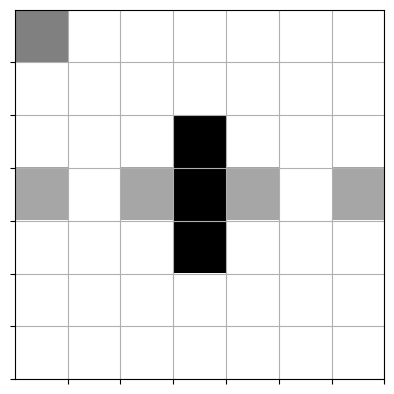

In [8]:
maze = np.array([
    [ 1.,  1.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  0.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  0.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  0.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  1.,  1.,  1.],
])

flags = [(3,0), (3,2), (3,4), (3,6)]

env = Tmaze(maze, flags)
show_env(env)

# Training a 7x7 Maze

In [14]:
model = build_model(env)

qt = Qtraining(
    model,
    env,
    n_epoch = 20,#200,
    max_memory = 50,#500,
    data_size = 10,#100,
    name = 'model_1'
)

qt.train()

1/1 [==============================] - 5s 5s/step


: 

: 